In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import comet_ml in the top of your file
from comet_ml import Experiment

# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="mri-epilepsy-classification", workspace="kondratevakate")
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/mri-epilepsy-classification/ccb0db0e501e4dd687884ecc90a203d3



In [3]:
!nvidia-smi

Fri May 22 19:25:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   47C    P0    45W / 250W |   8899MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [5]:
import sys
sys.path.append("../..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
# from utils import routine

### 0. Dataset

In [6]:
soloviev_data = MriClassification(sample='soloviev', data_type = 'img', ignore_missing=True,
                                  image_path='/home/datasets/fcd_classification_bank',
                                  targets_path ='../../targets/targets_fcd_bank.csv',
                                  coord_min=(35,35,35), img_shape=(180,180,180))

  1%|          | 1/181 [00:00<00:19,  9.20it/s]

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:14<00:00, 12.27it/s]


In [7]:
soloviev_data.scan_keys

array(['1.5T_soloviev'], dtype=object)

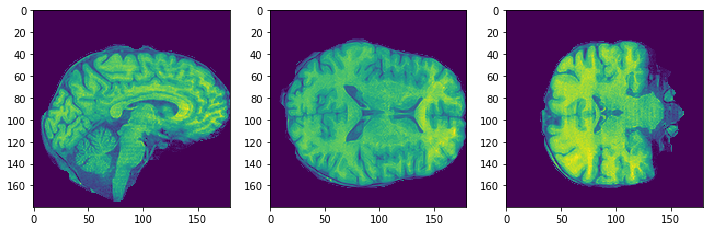

In [8]:
img, target, scan = soloviev_data[0]
plot_central_cuts(img)

In [9]:
soloviev_data.target.value_counts()

1    91
0    90
Name: fcd, dtype: int64

### 1. Classification w/o data normalisation


In [10]:
import sys
sys.path.append("../")
from models.cnn_model import CNN # models
from routine import * # validation and train

experiment.set_name("VoxCNN, baseline cv")

In [11]:

model_params = {
    "n_filters": 16,
    "stride": 2,
    "n_blocks": 4,
    "input_shape": (180,180,180),
    "n_fc_units": 180
}
train_dataset = soloviev_data
model_cnn = CNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_cnn)

batch_size = 10

split_ = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, val_idx = list(split_.split(X=np.arange(len(train_dataset)), y=train_dataset.target))[0]

train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

val_loader = DataLoader(Subset(train_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)

### 2. Train one epoch to finetune the model

Epoch 4 of 20 took 32.138s
  training loss (in-iteration): 	4.885135
  validation loss: 			5.406609
  training roc_auc_score: 			0.72
  validation roc_auc_score: 			0.43


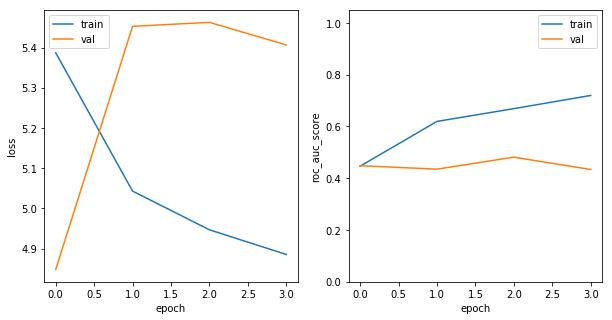

<Figure size 720x360 with 0 Axes>

  8%|▊         | 1/13 [00:01<00:19,  1.62s/it]

KeyboardInterrupt: 

In [12]:
%%time
torch.cuda.empty_cache()

training_params = {
    "model": model_cnn,
    "optimizer": optimizer,
    "scheduler": scheduler,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader,
    "device": device,
    "metric": roc_auc_score,
    "experiment": experiment,
    "max_epoch": 20,
    "verbose": 1,
}


last_train_loss, last_train_metric, last_val_loss, last_val_metric = train(**training_params)

### 3. Cross-validate on the best performing model

Epoch 1 of 20 took 31.810s
  training loss (in-iteration): 	4.780624
  validation loss: 			5.015141
  training roc_auc_score: 			0.85
  validation roc_auc_score: 			0.68


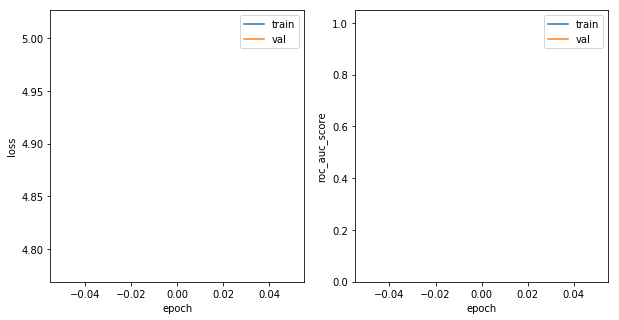

<Figure size 720x360 with 0 Axes>

 13%|█▎        | 2/15 [00:03<00:25,  1.97s/it]

KeyboardInterrupt: 

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score

cv_params = {
    "cnn_model": model_cnn,
    "batch_size": 10,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": roc_auc_score,
    "experiment": experiment,
    "max_epoch": 20,
}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))